# RDKit workshop

In the following, RDKit will be applied to explore a chemical dataset (Delaney) on the solubility of various substances in water (logS(mol/L)).

### Part 1: Data loading and exploration

Inspect the dataset and visualise the solubility distribution (EDA). Tasks:
- How many compounds are in the dataset?
- What is the average and range of the solubility values in the dataset?
- Are there extreme outliers (e.g. box plot)?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("delaney.csv")
df

,Compound ID,logS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [4]:
df.describe()


,logS
count,1144.000000
mean,-3.057997
std,2.096502
min,-11.600000
25%,-4.332250
50%,-2.870500
75%,-1.600000
max,1.580000


In [6]:
df.nunique() #checking for duplicates 1 less this means just one duplicate

Compound ID    1143
logS            743
SMILES         1128
dtype: int64

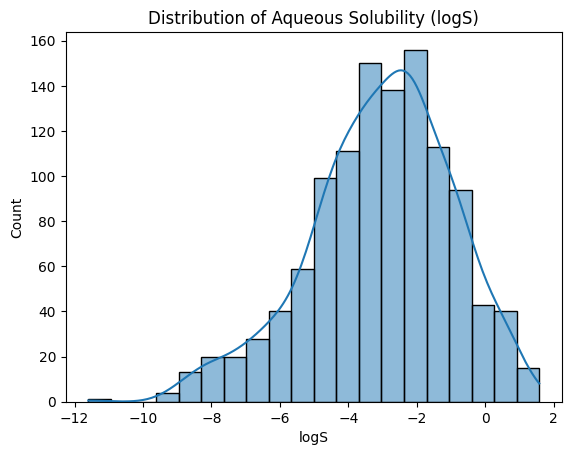

In [6]:

sns.histplot(df['logS'], bins=20, kde=True)
plt.title("Distribution of Aqueous Solubility (logS)")
plt.show()

<Axes: >

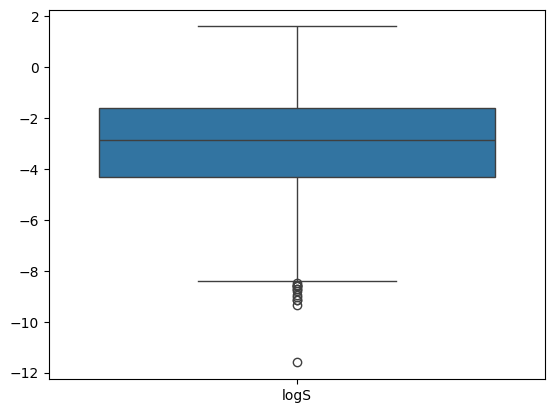

In [7]:
sns.boxplot(df)

### Part 2: Compute descriptors with RDKit

Calculate molecular descriptors from the SMILES. See snippet below for the syntax of doing so.

Tasks:
- Compute 5-10 descriptors based on the SMILES (e.g. use the apply() method in pandas) and add them to the DataFrame
- Find out if there is any correlation of the descriptors and the solubility (e.g. plots)

Some info on available descriptors: 
- https://github.com/hypowergravity/RDKitDescriptorExamples-
- https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html
- https://deepwiki.com/rdkit/rdkit/6.1-chemical-reactions#molecular-descriptors-and-properties

In [13]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Syntax for deriving descriptors:
# 1) convert smiles to Mol: mol = Chem.MolFromSmiles(smiles)
# 2) derive descriptor, e.g. for MolWt: descr = Descriptors.MolWt(mol)


descr_list = ["MolWt", "MolLogP", "TPSA","SPS"]

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)

df["MolWt"]= df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["MolLogP"]= df["SMILES"].apply(lambda s: Descriptors.MolLogP(Chem.MolFromSmiles(s)))
df["NumValenceElectrons"]= df["SMILES"].apply(lambda s: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(s)))
df["SPS"]= df["SMILES"].apply(lambda s: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(s)))
df["Phi"]= df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["MinAbsPartialCharge"]= df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["NumRadicalElectrons"]= df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))

df.head()

,Compound ID,logS,SMILES,MolWt,MolLogP,NumValenceElectrons,SPS,Phi,TPSA,MinAbsPartialCharge,NumRadicalElectrons
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,38,38,167.850,167.850,167.850,167.850
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,32,32,133.405,133.405,133.405,133.405
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,38,38,167.850,167.850,167.850,167.850
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,32,32,133.405,133.405,133.405,133.405
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,50,50,187.375,187.375,187.375,187.375


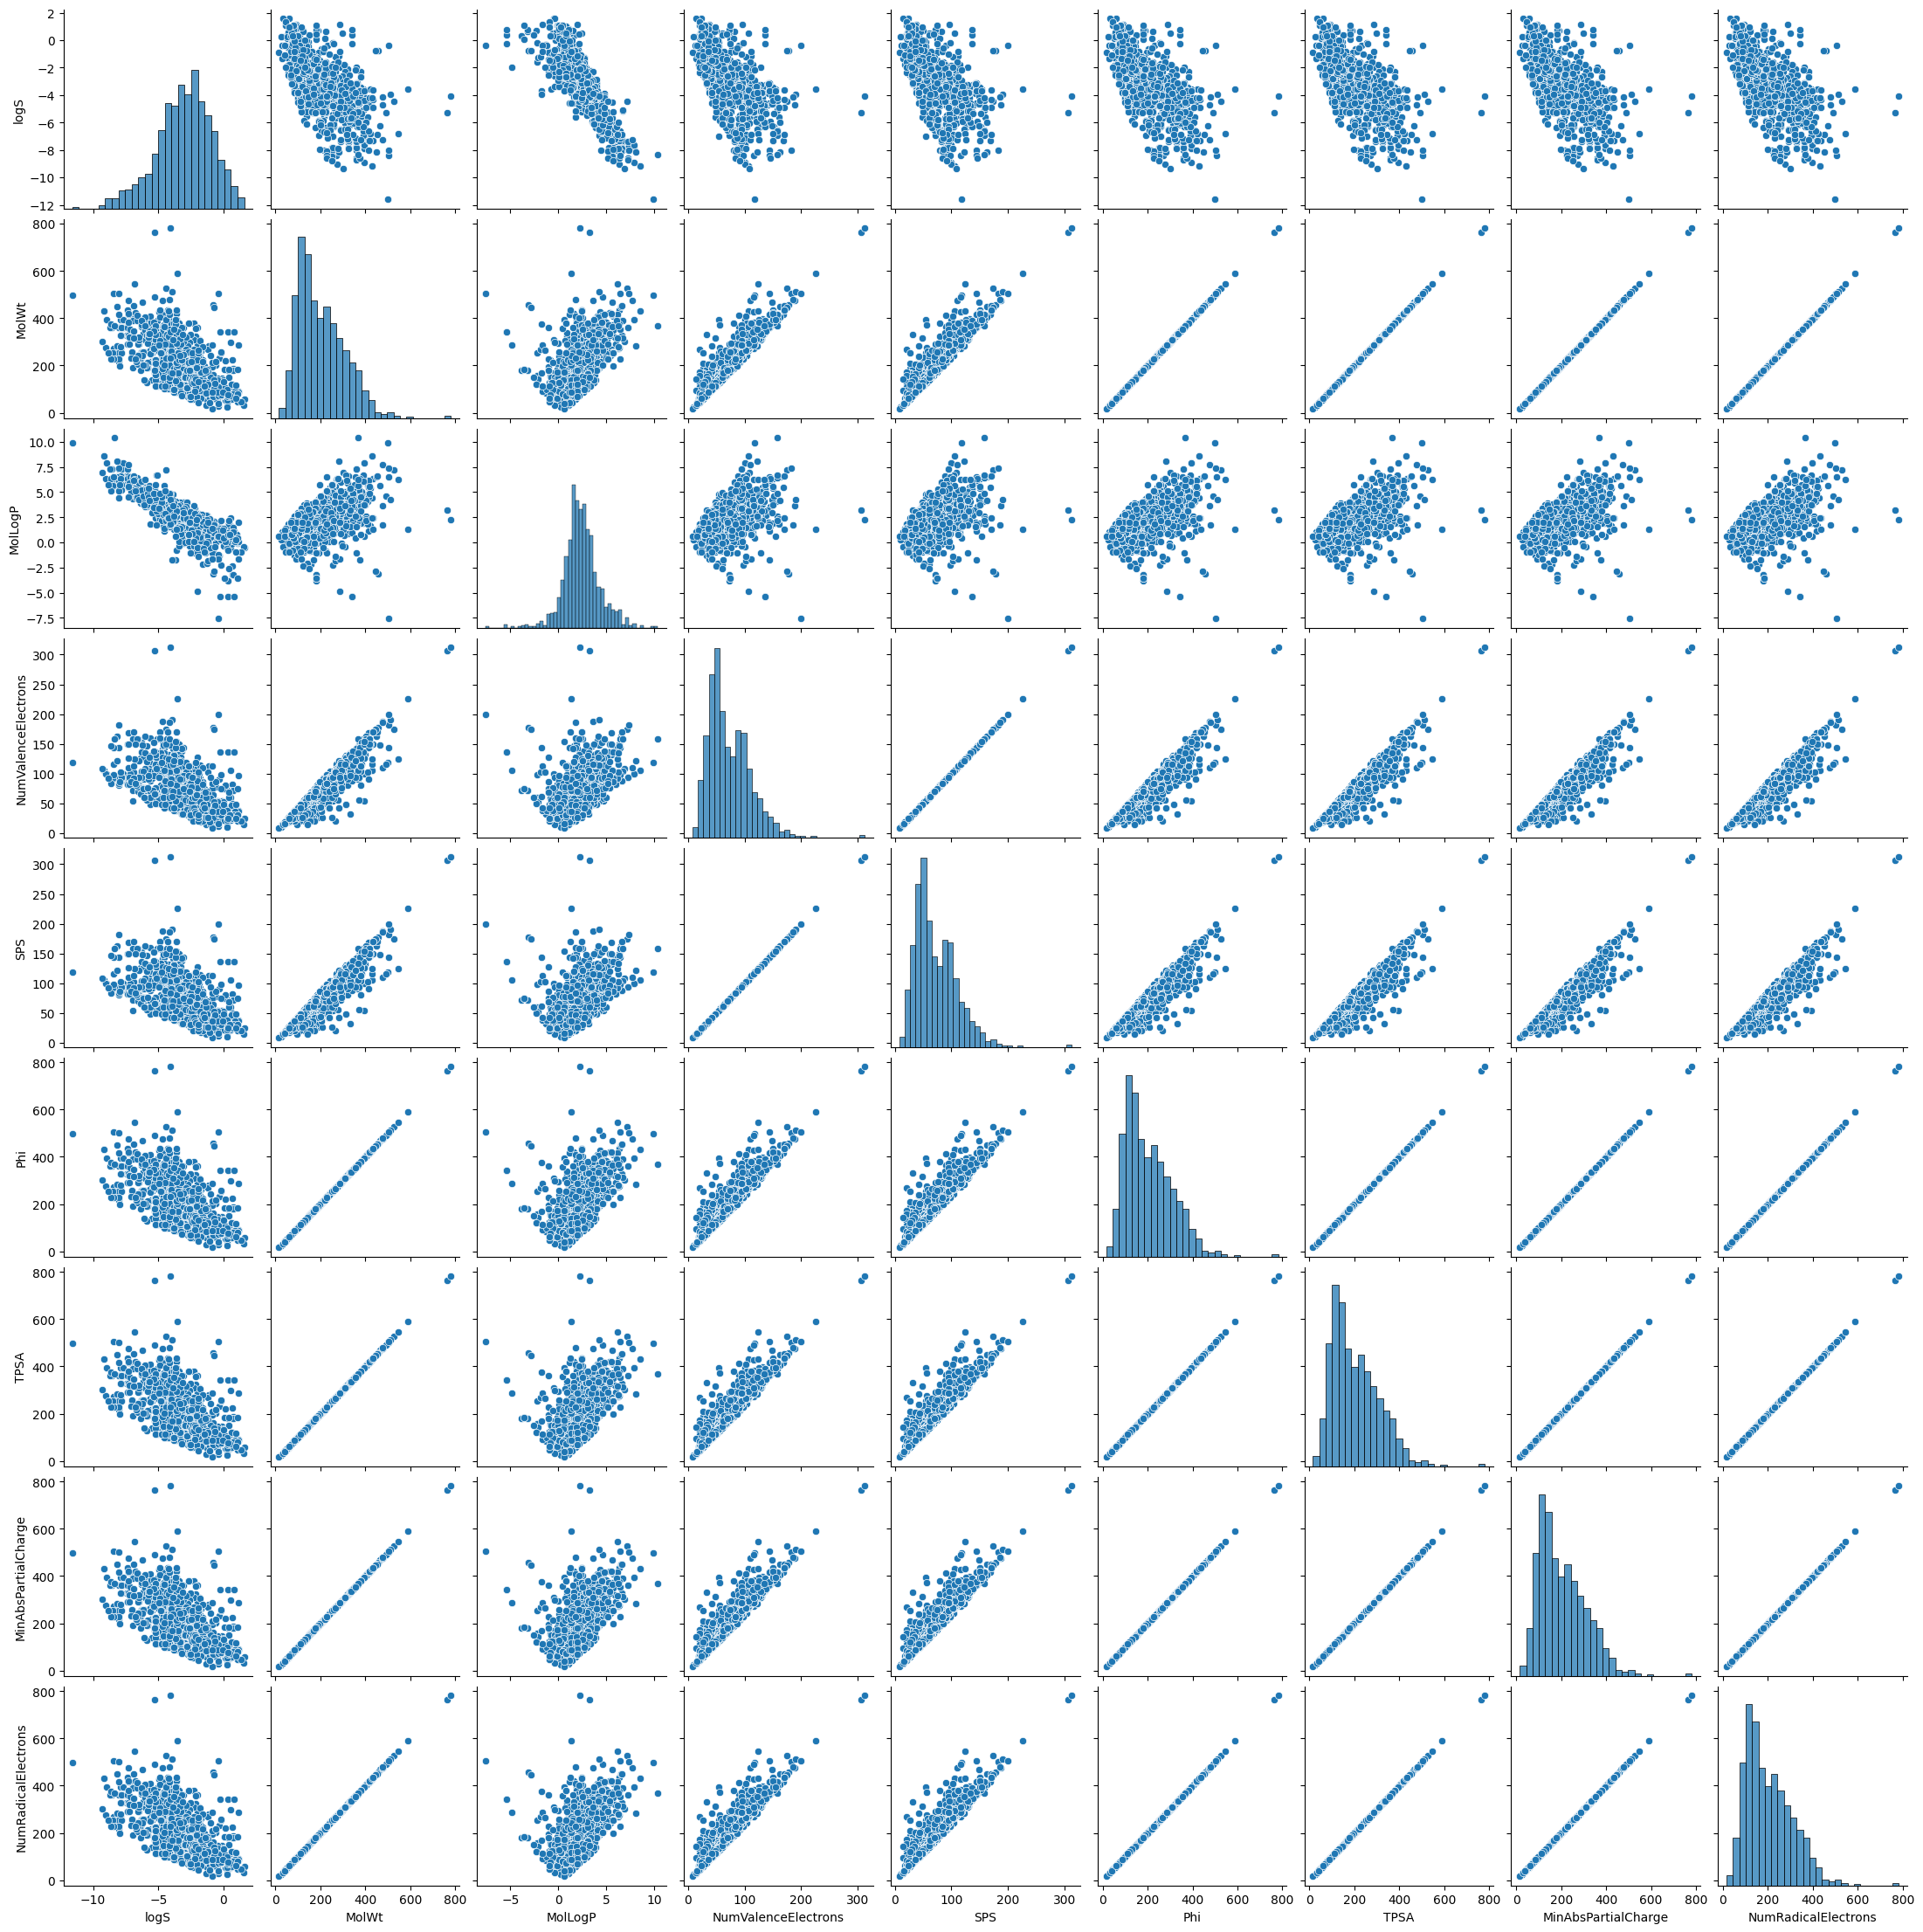

In [14]:
sns.pairplot(df)
plt.show()

### Part 3: Predict solubility (Regression Model)

Use the code below to predict the logS using a RandomForestRegressor:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df.drop(columns=["logS", "Compound ID", "SMILES"], axis=1) #drop columns which are descriptors because we can not use it further in regression calculation
y = df["logS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42) 
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("R²:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))
print("we have slight overfitting when we see those numbers in train accuracy and test accuracy we will learn this in DSA 104 lecture")

R²: 0.8728301730298464
RMSE: 0.7441548364020293
train accuracy: 0.9786388862724944
test accuracy: 0.8728301730298464
we have slight overfitting when we see those numbers in train accuracy and test accuracy we will learn this in DSA 104 lecture


Based on the EDA, which descriptors might influence the solubility the most?

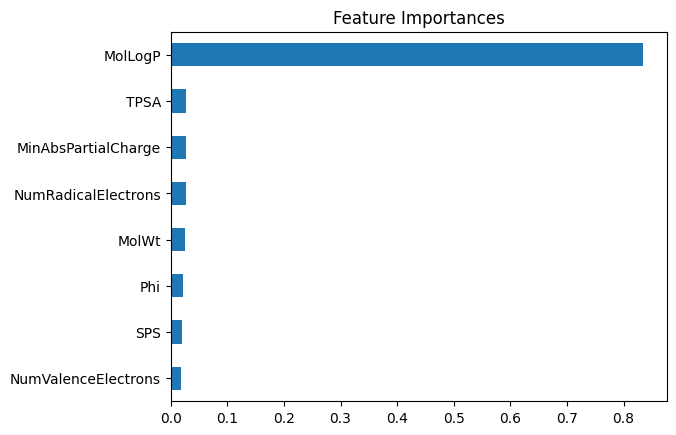

In [18]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

### Part 4: Similarity Search

Create fingerprints from the SMILES and add them to the dataframe.

In [25]:
from rdkit.Chem import rdFingerprintGenerator, DataStructs

# use e.g. the morgan FPG: mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)


def mol2fp(smiles):
    mol = Chem.MolFromSmiles(smiles) #generate mol file from smiles
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    fp = mfpgen.GetFingerprint(mol)
    return fp

df["fingerprint"]=df["SMILES"].apply(mol2fp)

df

,Compound ID,logS,SMILES,MolWt,MolLogP,NumValenceElectrons,SPS,Phi,TPSA,MinAbsPartialCharge,NumRadicalElectrons,mfpgen,fingerprint
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl,167.850,2.59540,38,38,167.850,167.850,167.850,167.850,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl,133.405,2.37650,32,32,133.405,133.405,133.405,133.405,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl,167.850,2.59380,38,38,167.850,167.850,167.850,167.850,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl,133.405,2.02890,32,32,133.405,133.405,133.405,133.405,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.91890,50,50,187.375,187.375,187.375,187.375,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC),287.343,1.98820,96,96,287.343,287.343,287.343,287.343,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,286.114,3.42130,94,94,286.114,286.114,286.114,286.114,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,308.333,3.60960,116,116,308.333,308.333,308.333,308.333,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,354.815,2.56214,122,122,354.815,354.815,354.815,354.815,<rdkit.Chem.rdFingerprintGenerator.Fingerprint...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)
df['Fingerprint'] = df['Mol'].apply(lambda m: mfpgen.GetFingerprint(m))

df.head()

,Compound ID,logS,SMILES,MolWt,MolLogP,NumValenceElectrons,Mol,Fingerprint
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,38,<rdkit.Chem.rdchem.Mol object at 0x000001C5CD2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,32,<rdkit.Chem.rdchem.Mol object at 0x000001C5CD2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,38,<rdkit.Chem.rdchem.Mol object at 0x000001C5CD2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,32,<rdkit.Chem.rdchem.Mol object at 0x000001C5CD2...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,50,<rdkit.Chem.rdchem.Mol object at 0x000001C5CD2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Calculate the Tanimoto similarity of the molecules in the dataframe in comparison to a molecule of your choice (e.g. caffeine, aniline, ethanol).

In [28]:
query_fp = mol2fp("CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
  #check similarity column this tanimo compares fingerprints of molecules and find matches in their structures 
df.describe()

,logS,MolWt,MolLogP,NumValenceElectrons,SPS,Phi,TPSA,MinAbsPartialCharge,NumRadicalElectrons,similarity
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,-3.057997,204.631675,2.449133,72.258741,72.258741,204.631675,204.631675,204.631675,204.631675,0.067665
std,2.096502,102.620500,1.866003,36.055991,36.055991,102.620500,102.620500,102.620500,102.620500,0.049719
min,-11.600000,16.043000,-7.571400,8.000000,8.000000,16.043000,16.043000,16.043000,16.043000,0.000000
25%,-4.332250,122.126000,1.414900,44.000000,44.000000,122.126000,122.126000,122.126000,122.126000,0.044444
50%,-2.870500,183.594500,2.340300,64.000000,64.000000,183.594500,183.594500,183.594500,183.594500,0.063661
75%,-1.600000,270.715750,3.406475,94.000000,94.000000,270.715750,270.715750,270.715750,270.715750,0.086394
max,1.580000,780.949000,10.388600,312.000000,312.000000,780.949000,780.949000,780.949000,780.949000,1.000000


In [30]:
df["similarity"].nlargest(10)

470     1.000000
1090    0.529412
626     0.525000
1091    0.457143
97      0.250000
804     0.195652
389     0.181818
1023    0.180000
1030    0.180000
1044    0.176471
Name: similarity, dtype: float64

### Part 5: Clustering molecules by strucutre

Use fingerprints to group molecules into clusters (using k-means clustering) and visualise via PCA. Tasks:
- Experiment with different numbers of clusters
- Compute the average solubility per cluster
- Do certain clusters correspond to highly or poorly soluble compounds?

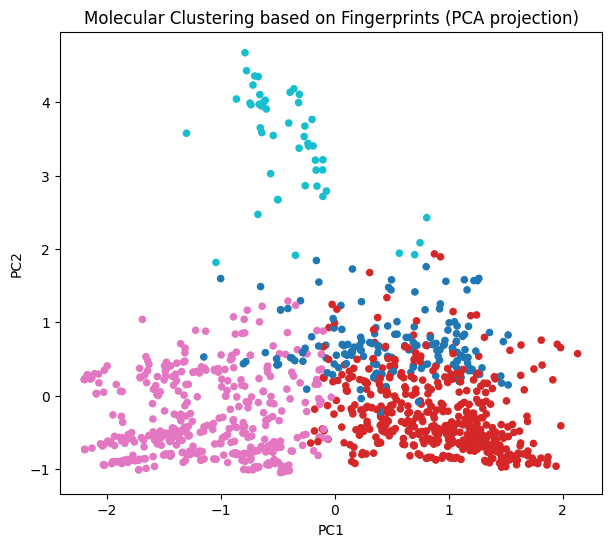

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fps = df["fingerprint"].to_list()

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)

# K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(fps)
df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=20)
plt.title("Molecular Clustering based on Fingerprints (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [34]:
print(df.groupby("cluster")["logS"].mean())

cluster
0   -3.678024
1   -3.569267
2   -2.120079
3   -4.447604
Name: logS, dtype: float64


In [18]:
df["has_aromat"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(Chem.MolFromSmarts("a")))
pd.crosstab(df["cluster"], df["has_aromat"])

has_aromat,False,True
cluster,,
0,4,160
1,17,470
2,405,40
3,43,5


### Part 6: Substructure Search via SMARTS

Search for specific functional groups or chemical motifs within the dataset using SMARTS (SMiles ARbitrary Target Specification): e.g. alcohol = "[OX2H]", carboxylic acid = "C(=O)[OH]", aromatic compounds = "a", amines = "[NX3;H2,H1;!$(NC=O)]"

See here for a more detailed list of SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html 

Tasks:
- Count how many molecules contain each functional group (method: Mol.HasSubstructMatch(SMARTS)).
- Compare average solubility for molecules with vs. without each substructure.
- Visualize with a bar plot.

In [31]:
from rdkit import Chem

patterns = {
    "Hydroxyl": Chem.MolFromSmarts("[OX2H]"), "Phenol":  Chem.MolFromSmarts("[OH]c1ccccc1")
}
#"carboxylic acid" :  Chem.MolFromSmarts("C(=O)[OH]"

method : Mol.HasSubstructMatch(SMARTS)

In [24]:
df[list(patterns.keys())].sum()

KeyError: "None of [Index(['Phenol'], dtype='object')] are in the [columns]"

In [29]:
print(df.columns.tolist())
missing = [k for k in patterns.keys() if k not in df.columns]
print("Missing:", missing)

['Compound ID', 'logS', 'SMILES', 'MolWt', 'MolLogP', 'NumValenceElectrons', 'Mol', 'Fingerprint', 'similarity', 'cluster', 'has_aromat']
Missing: ['Hydroxyl', 'Phenol']


In [28]:
for name in patterns.keys():
    print(df.groupby(name)["logS"].mean())

KeyError: 'Hydroxyl'

In [ ]:
import seaborn as sns
means = {}

for name in patterns.keys():
    mean_series = df.groupby(name)["logS"].mean()
    if len(mean_series) > 1:
        val = mean_series.iloc[1]
        means[name] = val
    else:
        print(f"No {name} in dataset")

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.title("Average Solubility by Functional Group Presence")
plt.ylabel("Mean logS")
plt.show()